In [1]:
#1 Create a dataset and save to computer.

import cdsapi

client = cdsapi.Client(
    url='https://cds.climate.copernicus.eu/api',
    key='ee4c4632-35d5-4d92-bb7b-f556e11f998f'
)

client.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': [
            'sea_surface_temperature',
            'total_column_water_vapour'
        ],
        'year': [
            '1979', '1980', '1981', '1982', '1983', '1984',
            '1985', '1986', '1987', '1988', '1989', '1990',
            '1991', '1992', '1993', '1994', '1995', '1996',
            '1997', '1998', '1999', '2000', '2001', '2002',
            '2003', '2004', '2005', '2006', '2007', '2008',
            '2009', '2010', '2011', '2012', '2013', '2014',
            '2015', '2016', '2017', '2018', '2019', '2020',
            '2021', '2022', '2023', '2024'
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12'
        ],
        'time': ['00:00'],
        'format': 'netcdf',
        # Pacific Basin (65°N–65°S, 120°E–60°W = 300°E)
        'area': [65, 120, -65, 300],
    },
    'pacific_sst_tcwv_monthly_1979_2024.nc'
)


2025-10-24 11:48:19,512 INFO Request ID is 8d8bc5b0-cc1c-4c5a-ac0c-6e6030510f27
2025-10-24 11:48:19,663 INFO status has been updated to accepted
2025-10-24 11:48:28,427 INFO status has been updated to successful


'pacific_sst_tcwv_monthly_1979_2024.nc'

In [2]:
import numpy as np
import xarray as xr
import dask

ds = xr.open_dataset("pacific_sst_tcwv_monthly_1979_2024.nc", chunks="auto")

print(ds)

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 552, latitude: 521, longitude: 721)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    expver      (valid_time) <U4 9kB dask.array<chunksize=(552,), meta=np.ndarray>
Data variables:
    sst         (valid_time, latitude, longitude) float32 829MB dask.array<chunksize=(276, 262, 362), meta=np.ndarray>
    tcwv        (valid_time, latitude, longitude) float32 829MB dask.array<chunksize=(276, 262, 362), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:            

In [3]:
#2 Copy From HW Description to deseasonalize the data trend


def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z


In [4]:
# Time into one chunk for speed

ds = ds.chunk({"valid_time": -1})


# Detrend both SST and TCWM
detr = linear_detrend(ds[["sst", "tcwv"]], time_dim="valid_time")
anom, z = monthly_anom_and_z(detr, time_dim="valid_time",
                             base_period=("1981-01-01", "2010-12-31"))

In [5]:
print(type(z), list(z.data_vars)) 

<class 'xarray.core.dataset.Dataset'> ['sst', 'tcwv']


In [6]:
!pip install scikit-learn
from sklearn.preprocessing import StandardScaler

sst = anom['sst']

# Flatten
nt, nlat, nlon = sst.shape
sst_2d = sst.values.reshape(nt, nlat*nlon)

# Standardize
scaler = StandardScaler()
sst_standardized_2d = scaler.fit_transform(sst_2d)

# Reshape
sst_standardized = sst_standardized_2d.reshape(nt, nlat, nlon)
sst_standardized_da = xr.DataArray(
    sst_standardized,
    coords=sst.coords,
    dims=sst.dims,
    name="sst_standardized"
)

# Needed help from ChatGPT on this one


/home/alexakt2/envs/xarray-climate/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/alexakt2/envs/xarray-climate/lib/python3.13/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/alexakt2/envs/xarray-climate/lib/python3.13/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/alexakt2/envs/xarray-climate/lib/python3.13/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [ ]:
!pip install eofs

# Error with "time". Needed to rename "valid_time" to "time"
sst_stnd_rename = sst_standardized_da.rename({'valid_time': 'time'})

from eofs.xarray import Eof
from eofs.examples import example_data_path

# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(sst_stnd_rename.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst_stnd_rename, weights=wgts)

In [ ]:
# Retrieve the first 5 EOFs, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
eof5 = solver.eofsAsCorrelation(neofs=5)
pc5 = solver.pcs(npcs=5, pcscaling=1)

/home/alexakt2/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


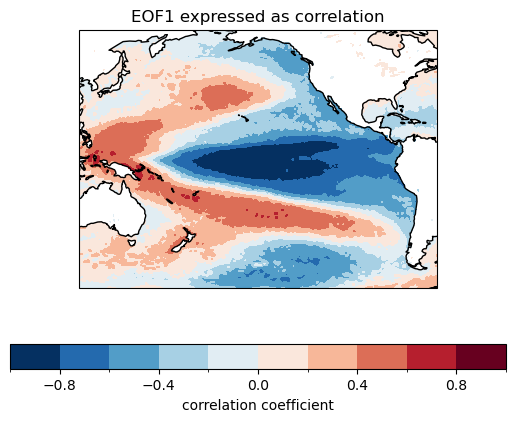

/home/alexakt2/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


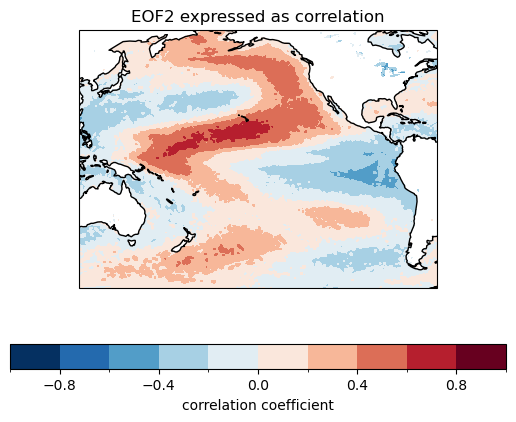

/home/alexakt2/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


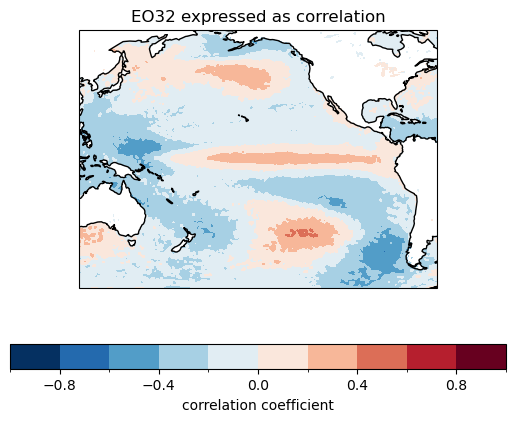

/home/alexakt2/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


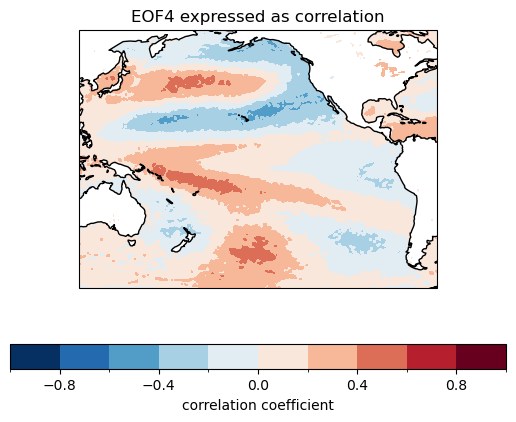

/home/alexakt2/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


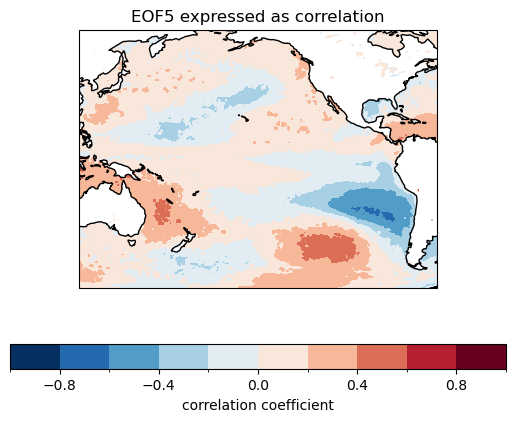

In [ ]:
# Plot the first 5 EOFs

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

clevs = np.linspace(-1, 1, 11)

# EOF1
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof5[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient')
ax.set_title('EOF1 expressed as correlation')
plt.show()

# EOF2
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof5[1].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient')
ax.set_title('EOF2 expressed as correlation')
plt.show()

# EOF3
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof5[2].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient')
ax.set_title('EO32 expressed as correlation')
plt.show()

# EOF4
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof5[3].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient')
ax.set_title('EOF4 expressed as correlation')
plt.show()

# EOF5
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = eof5[4].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('correlation coefficient')
ax.set_title('EOF5 expressed as correlation')
plt.show()

(2.549491879479007e-16, 0.19245938956737518)

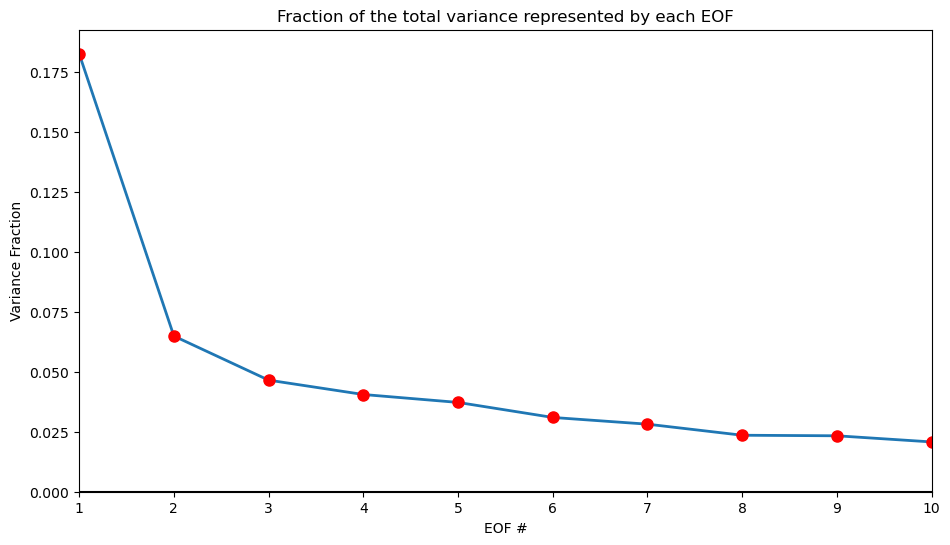

In [ ]:
varfrac = solver.varianceFraction()

# Plot the fraction of variance explained by each EOF
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[0:10], linewidth=2)
plt.plot(eof_num, varfrac[0:10], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 11))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 10)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

/home/alexakt2/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


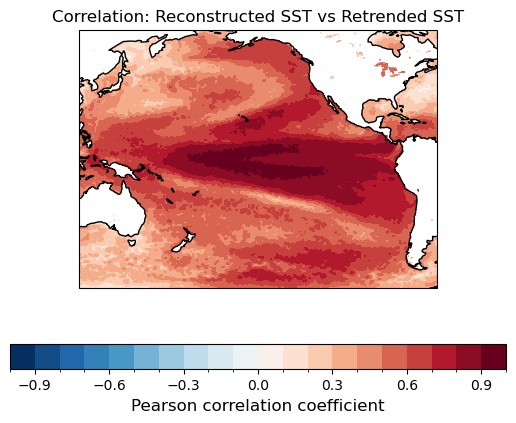

In [ ]:
# 5

reconstruction = solver.reconstructedField(5)

# Rename "valid time"
sst_anom = anom['sst'].rename({'valid_time': 'time'})

#Issues with dimensions
sst_anom = sst_anom.transpose('time', 'latitude', 'longitude')
reconstruction = reconstruction.transpose('time', 'latitude', 'longitude')

# Pearson correlation coefficient
corr_map = xr.corr(reconstruction, sst_anom, dim='time')


# Plot correlation map
clevs = np.linspace(-1, 1, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = corr_map.plot.contourf(
    ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
    add_colorbar=False, transform=ccrs.PlateCarree()
)
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('Pearson correlation coefficient', fontsize=12)
ax.set_title('Correlation: Reconstructed SST vs Retrended SST')
plt.show()


/home/alexakt2/envs/xarray-climate/lib/python3.13/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


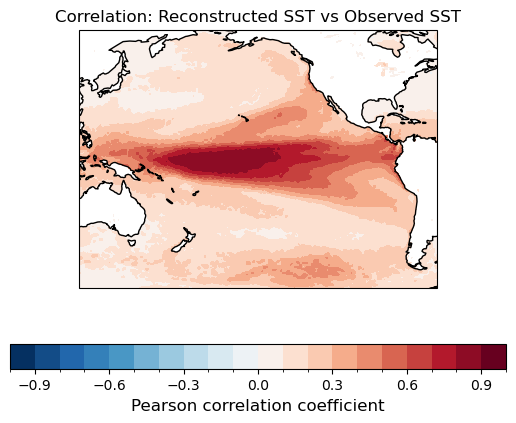

In [ ]:
# Rename "valid time"
sst_ds = ds['sst'].rename({'valid_time': 'time'})

#Issues with dimensions
sst_ds = sst_ds.transpose('time', 'latitude', 'longitude')

# Pearson correlation coefficient
corr_map_2 = xr.corr(reconstruction, sst_ds, dim='time')


# Plot correlation map
clevs = np.linspace(-1, 1, 21)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = corr_map_2.plot.contourf(
    ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
    add_colorbar=False, transform=ccrs.PlateCarree()
)
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label('Pearson correlation coefficient', fontsize=12)
ax.set_title('Correlation: Reconstructed SST vs Observed SST')
plt.show()


In [ ]:
# Rename "valid time"
tcwv = z['tcwv'].rename({'valid_time': 'time'})

#Issues with dimensions
tcwv = tcwv.transpose('time', 'latitude', 'longitude')
reconstruction = reconstruction.transpose('time', 'latitude', 'longitude')


corr_map_3 = xr.corr(reconstruction, tcwv, dim='time')


clevs = np.linspace(-1, 1, 11)

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
fill = corr_map_3.plot.contourf(
    ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
    add_colorbar=False, transform=ccrs.PlateCarree()
)
ax.add_feature(cfeature.COASTLINE, color='k')
cb = plt.colorbar(fill, orientation='horizontal')
cb.set_label("Pearson correlation coefficient")
ax.set_title("Correlation between reconstructed and Total Column Water Vapor")
plt.show()

